In [1]:
pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python3.13 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import time
import json
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from typing import List, Tuple
from collections import Counter
import matplotlib.pyplot as plt
from flwr.server.strategy import FedAvg
from flwr.common import Metrics, Context
from flwr.simulation import run_simulation
from sklearn.model_selection import train_test_split
from flwr.client import Client, ClientApp, NumPyClient
from sklearn.preprocessing import LabelEncoder, StandardScaler
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, classification_report, log_loss, precision_score, f1_score, recall_score

In [10]:
%env IIOT_DATASET_FILE_PATH /Users/macbookpro/Downloads/Edge IIoTset/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv

env: IIOT_DATASET_FILE_PATH=/Users/macbookpro/Downloads/Edge IIoTset/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv


In [12]:
DS_FILE_PATH = os.environ.get("IIOT_DATASET_FILE_PATH")
if DS_FILE_PATH:
    print(f"File Path: {DS_FILE_PATH}")
else:
    print("File path environment variable not set.")

df = pd.read_csv(
        DS_FILE_PATH,
        low_memory=False
    )

df.head()

File Path: /Users/macbookpro/Downloads/Edge IIoTset/Edge-IIoTset dataset/Selected dataset for ML and DL/ML-EdgeIIoT-dataset.csv


,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


In [13]:
print('Dataset shape: ', df.shape)
print(df.columns.tolist())

Dataset shape:  (157800, 63)
['frame.time', 'ip.src_host', 'ip.dst_host', 'arp.dst.proto_ipv4', 'arp.opcode', 'arp.hw.size', 'arp.src.proto_ipv4', 'icmp.checksum', 'icmp.seq_le', 'icmp.transmit_timestamp', 'icmp.unused', 'http.file_data', 'http.content_length', 'http.request.uri.query', 'http.request.method', 'http.referer', 'http.request.full_uri', 'http.request.version', 'http.response', 'http.tls_port', 'tcp.ack', 'tcp.ack_raw', 'tcp.checksum', 'tcp.connection.fin', 'tcp.connection.rst', 'tcp.connection.syn', 'tcp.connection.synack', 'tcp.dstport', 'tcp.flags', 'tcp.flags.ack', 'tcp.len', 'tcp.options', 'tcp.payload', 'tcp.seq', 'tcp.srcport', 'udp.port', 'udp.stream', 'udp.time_delta', 'dns.qry.name', 'dns.qry.name.len', 'dns.qry.qu', 'dns.qry.type', 'dns.retransmission', 'dns.retransmit_request', 'dns.retransmit_request_in', 'mqtt.conack.flags', 'mqtt.conflag.cleansess', 'mqtt.conflags', 'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg_decoded_as', 'mqtt.msg', 'mqtt.msgtype', 'mqtt.proto_le

In [14]:
# Replace infinite values with NaNs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
df.dropna(inplace=True)

print('Dataset shape: ', df.shape)

Dataset shape:  (157800, 63)


In [15]:
cols_to_drop = [
    'frame.time', 'ip.src_host', 'ip.dst_host', 'http.file_data', 'http.request.uri.query', 'http.referer',
    'http.request.full_uri', 'dns.qry.name', 'mqtt.topic', 'mqtt.msg', 'mqtt.msg_decoded_as', 'mqtt.protoname',
    'arp.dst.proto_ipv4', 'arp.src.proto_ipv4', 'tcp.options', 'tcp.payload', 'tcp.srcport', 'dns.qry.name.len', 'mqtt.conack.flags'
]

df.drop(columns=cols_to_drop, inplace=True)

In [16]:
# Retrieve attack types
attack_types_label = df['Attack_type'].unique()
attack_types = df['Attack_type']
attack_df = pd.DataFrame(attack_types, columns=['Attack_type'])

In [17]:
# Encode categorical columns 
categorical_cols = ['http.request.method', 'http.request.version', 'http.response', 'mqtt.msgtype',
                    'mqtt.ver', 'mqtt.conflags', 'Attack_type']

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

In [18]:
# Seperate Label
label_col = 'Attack_label'
features = df.drop(columns=[label_col])
labels = df[label_col]

# Ensure all selected columns are numeric
features = features.select_dtypes(include=[np.number])

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [19]:
# Reassemble final dataset
processed_df = pd.DataFrame(scaled_features, columns=features.columns)
processed_df[label_col] = labels.reset_index(drop=True)

# Data Visualization

### Attack class label Distribution

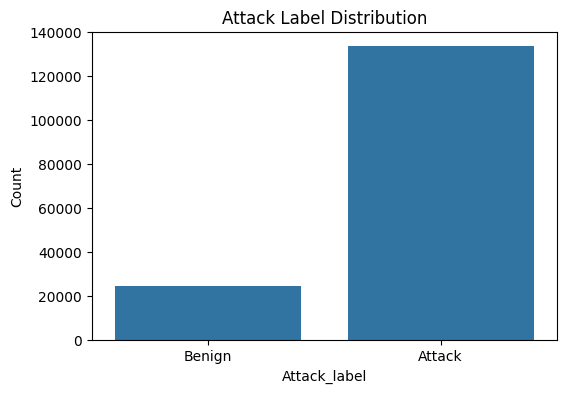

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(x='Attack_label', data=processed_df)
plt.title('Attack Label Distribution')
plt.xticks([0, 1], ['Benign', 'Attack'])
plt.ylabel('Count')
plt.show()

### Attack Types breakdown

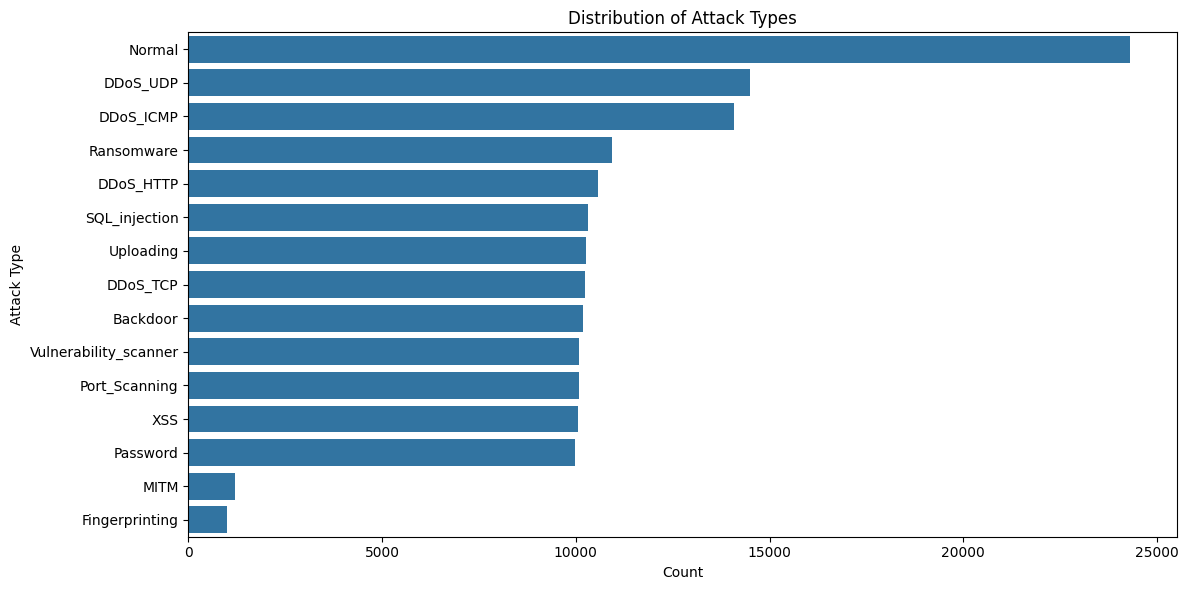

In [21]:
plt.figure(figsize=(12, 6))
sns.countplot(y='Attack_type', data=attack_df, order=attack_df['Attack_type'].value_counts().index)
plt.title('Distribution of Attack Types')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.show()

### Feature Correlation Heatmap

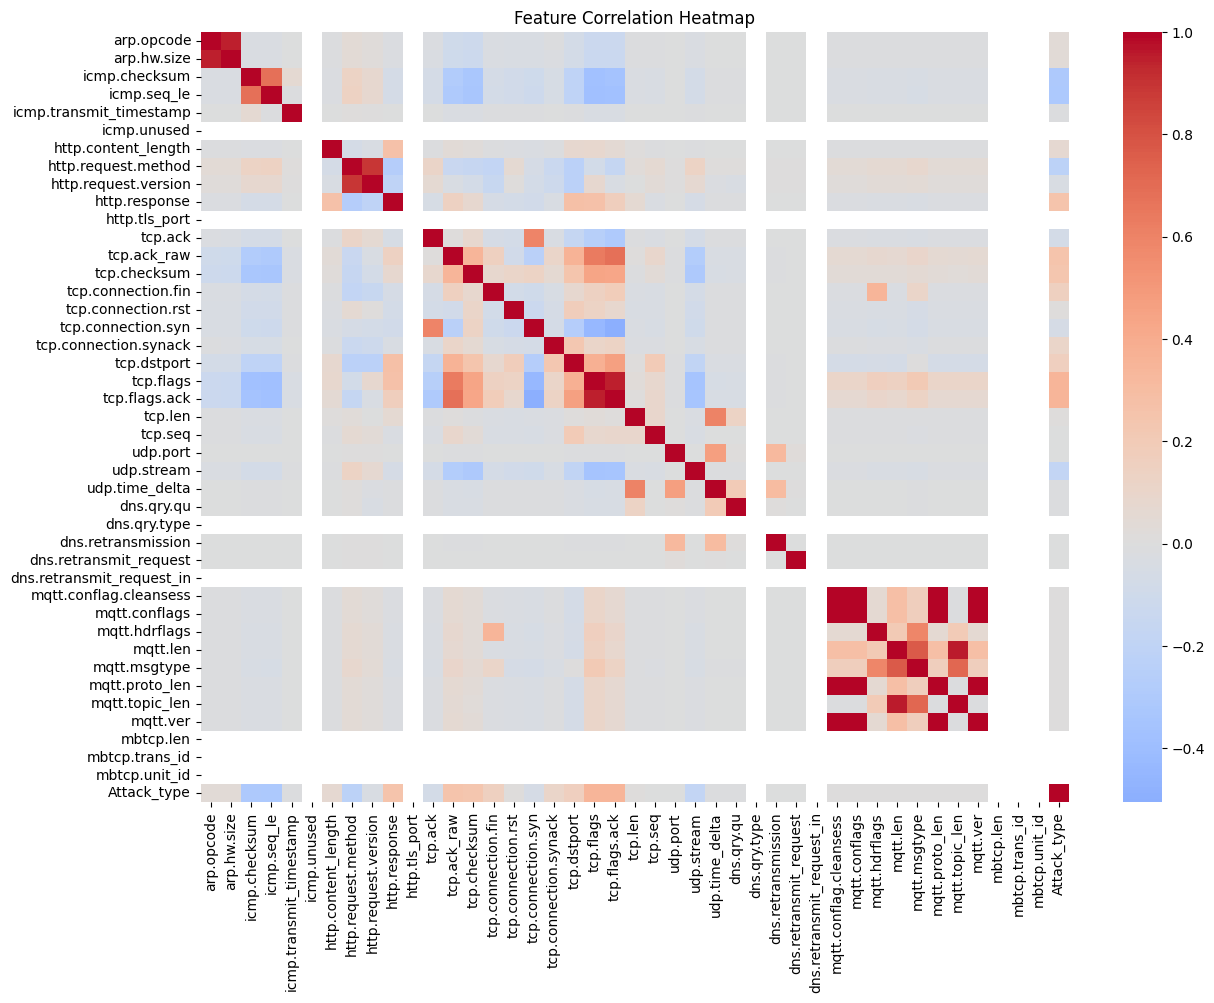

In [22]:
plt.figure(figsize=(14, 10))
correlation_matrix = processed_df.drop(columns=['Attack_label']).corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### Distribution of some features (Benign Vs Attack)

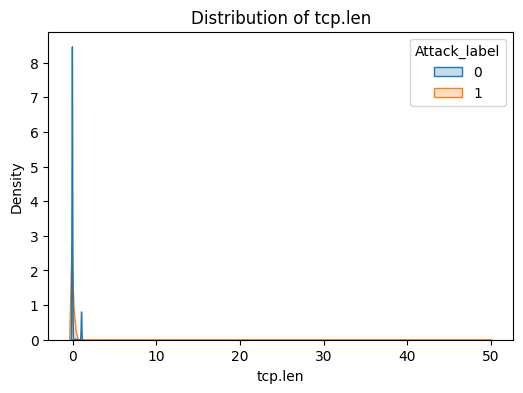

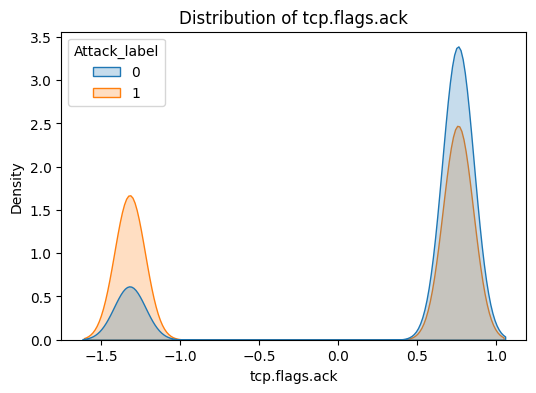

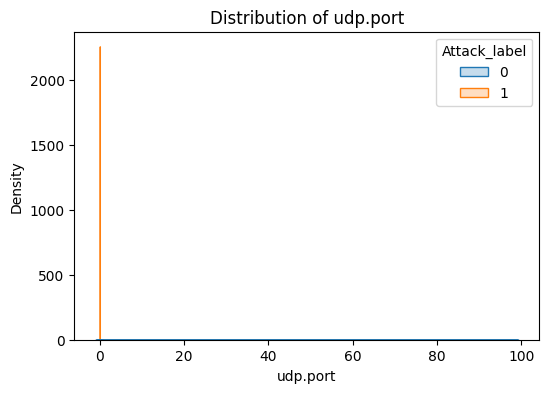

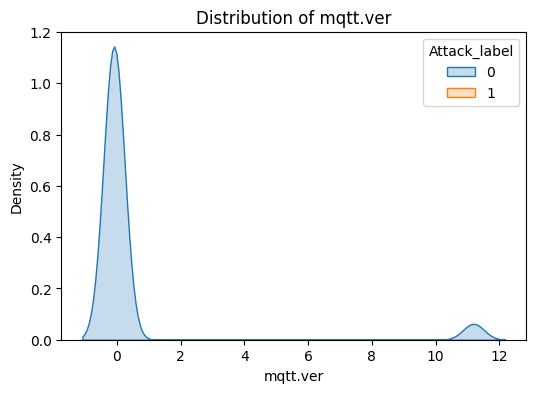

In [23]:
selected_features = ['tcp.len', 'tcp.flags.ack', 'udp.port', 'mqtt.ver']
for feature in selected_features:
    if feature in processed_df.columns:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=processed_df, x=feature, hue='Attack_label', fill=True, common_norm=False, warn_singular=False)
        plt.title(f'Distribution of {feature}')
        plt.show()

### Top N features by Variance or Mean difference

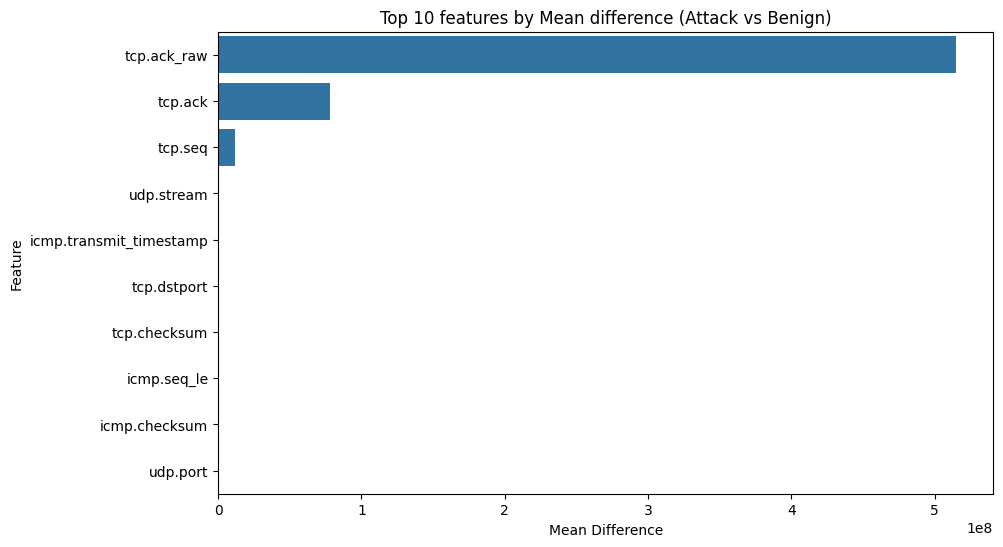

In [24]:
feature_stats = pd.DataFrame()
feature_stats['mean_diff'] = features[labels == 1].mean() - features[labels == 0].mean()
top_features = feature_stats['mean_diff'].abs().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 features by Mean difference (Attack vs Benign)")
plt.xlabel("Mean Difference")
plt.ylabel("Feature")
plt.show()

# Feature Selection

In [25]:
# Seperate features (X) from target (y)
X = processed_df.drop(columns=['Attack_label', 'Attack_type'])
y = processed_df['Attack_label']

In [ ]:
# Ranking features by importance

# Select top K features
k = 20
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Top {} features: ".format(k))
print(selected_features.tolist())

# Save selected features to a new dataframe
X_reduced = pd.DataFrame(X_selected, columns=selected_features)

### Visualize Feature Importance

In [ ]:
scores = selector.scores_
feature_scores = pd.Series(scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_scores.head(k).plot(kind='barh')
plt.title("Top {} Feature Importance (Mutual Information)".format(k))
plt.gca().invert_yaxis()
plt.show()

### Split the dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Model selection

In [ ]:
import time
import xgboost as xgb
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(),
    "MLP": MLPClassifier(hidden_layer_sizes=(64,), max_iter=300)
}

result = {}

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    result[name] = {
    "accuracy": acc,
    "train_time": round(end - start, 2)
    }
    print(f"\n{name}")
    print(f"Accuracy: {acc:.4f}, Train time: {end - start:.2f}s")
    print(classification_report(y_test, y_pred))

### Get best model parameters

In [ ]:
# Define parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# define base model
xgb_clf = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    verbosity=0
)

In [ ]:
# Search for parameters
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit and evaluate
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nBest Parameters: {random_search.best_params_}")
print(f"Accuracy after tuning: {acc:.4f}, Train time: {end - start:.2f}s")
print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 1, 'colsample_bytree': 0.8}
Accuracy after tuning: 0.9991, Train time: 4.51s
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      4860
           1       1.00      1.00      1.00     26700

    accuracy                           1.00     31560
   macro avg       1.00      1.00      1.00     31560
weighted avg       1.00      1.00      1.00     31560



## Federated learning

In [52]:
pip install flwr

  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached click-8.1.8-py3-none-any.whl.metadata (2.3 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.0/540.0 kB 1.8 MB/s eta 0:00:000m eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 3.1 MB/s eta 0:00:003.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 4.1 MB/s eta 0:00:004.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.4 MB/s eta 0:00:00 MB/s eta 0:00:01
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
Using cached click-8.1.8-py3-none-any.whl (98 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kerne

In [53]:
import flwr as fl

### Set up base centralized model client class

In [ ]:
# define model parameters
XGB_PARAMS = {
    "max_depth": 5,
    "learning_rate": 0.2,
    "n_estimators": 100,
    "subsample": 0.8,
    "colsample_bytree": 0.5,
    "objective": "binary:logistic",
    "tree_method": "hist",
    "gamma": 1,
    "reg_lambda": 1,
    "eval_metric": "logloss",
    "seed": 42
}

In [ ]:
# Define model client class
class XGBoostClient(NumPyClient):
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = self._create_model()
        self.is_model_fit = False
        
    def _create_model(self):
        """Create a new XGBoost model with the predefined parameters"""
        params = XGB_PARAMS.copy()
        
        # Handle class imbalance for each client
        counter = Counter(self.y_train)
        neg = counter.get(0, 1)
        pos = counter.get(1, 1)
        scale_pos_weight = neg / pos if pos != 0 else 1.0
        params["scale_pos_weight"] = scale_pos_weight

        return xgb.XGBClassifier(**params)

    def get_parameters(self, config=None):
        """Return model parameters as feature importances"""
        try:
            # If the model hasn't been fit yet, we need to fit it before getting parameters
            if not self.is_model_fit:
                print(f"Fitting initial model with classes: {np.unique(self.y_train)}")
                self.model.fit(self.X_train, self.y_train)
                self.is_model_fit = True
            
            # Create a simple dictionary of feature importances
            param_dict = {"feature_importances": self.model.feature_importances_.tolist()}
            
            # Convert to bytes for Flower protocol
            return [json.dumps(param_dict).encode("utf-8")]
        except Exception as e:
            print(f"Error in get_parameters: {e}")
            param_dict = {"feature_importances": [1.0/self.X_train.shape[1]] * self.X_train.shape[1]}
            return [json.dumps(param_dict).encode("utf-8")]

    def set_parameters(self, parameters):
        """Set model parameters - in this approach we're not sharing model parameters"""
        # Make sure the model is initialized and fit
        if not self.is_model_fit:
            print(f"Training local model with {len(self.y_train)} samples")
            self.model.fit(self.X_train, self.y_train)
            self.is_model_fit = True
        return self

    def fit(self, parameters, config):
        """Train the model on local data"""
        print(f"Fitting client with {len(self.y_train)} samples, classes: {np.unique(self.y_train)}")
        
        # Make sure model is initialized and trained
        if not self.is_model_fit:
            self.model.fit(self.X_train, self.y_train)
            self.is_model_fit = True
        else:
            # do additional training here
            self.model.fit(self.X_train, self.y_train, xgb_model=self.model)
            pass
            
        # Return current model's parameters
        return self.get_parameters(), len(self.X_train), {}
    
    def evaluate(self, parameters, config):
        """Evaluate model"""
        # Ensure model is fit before evaluation
        if not self.is_model_fit:
            print("Fitting model before evaluation")
            self.model.fit(self.X_train, self.y_train)
            self.is_model_fit = True
            
        try:
            # Ensure y_test is in the right format - convert to numpy array if it's a pandas Series
            y_test_np = self.y_test.values if hasattr(self.y_test, 'values') else self.y_test
            
            y_pred = self.model.predict(self.X_test)
            
            # Ensure the predictions are in the right format
            if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
                # get the class with highest probability
                y_pred_classes = np.argmax(y_pred, axis=1)
            else:
                y_pred_classes = y_pred
                
            try:
                y_pred_proba = self.model.predict_proba(self.X_test)
                # Check and convert labels to binary indicators for log_loss calculation
                n_classes = len(np.unique(y_test_np))
                if y_pred_proba.shape[1] != n_classes:
                    print(f"Warning: probability shape {y_pred_proba.shape} doesn't match classes {n_classes}")
                    loss = -np.mean(np.log(np.maximum(y_pred_proba[np.arange(len(y_test_np)), y_test_np], 1e-10)))
                else:
                    loss = log_loss(y_test_np, y_pred_proba)
            except Exception as e:
                print(f"Error calculating loss: {e}")
                loss = float("inf")
            
            accuracy = accuracy_score(y_test_np, y_pred_classes)
            print(f"Evaluation:\n Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
            return loss, len(self.X_test), {"accuracy": float(accuracy)}
        except Exception as e:
            print(f"Error in evaluate: {e}")
            return float("inf"), len(self.X_test), {"accuracy": 0.0}

In [ ]:
# Define federated learning strategy class
class FederatedXGBoostStrategy(FedAvg):
    """Strategy for federated XGBoost that doesn't aggregate model parameters"""
    
    def aggregate_fit(self, server_round, results, failures):
        """Doesn't actually aggregate - just return None to skip parameter distribution"""
        print(f"Round {server_round}: {len(results)} results, {len(failures)} failures")
        return None, {}


In [ ]:
# Aggregate accuracy of all clients
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregate accuracy metrics from multiple clients."""
    # Check if we have metrics to average
    if not metrics:
        return {"accuracy": 0.0}
        
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    
    # Check if we have any examples
    if sum(examples) == 0:
        return {"accuracy": 0.0}
        
    return {"accuracy": sum(accuracies) / sum(examples)}

### Split dataset for each FL client

In [ ]:
NUM_CLIENTS=10
client_datasets = []

# Stratified split to ensure class balance across clients
grouped = {}
unique_labels = y.unique()
for label in unique_labels:
    idx = y[y == label].index
    grouped[label] = idx
    
# Create client partitions with balanced class distribution
client_indices = [[] for _ in range(NUM_CLIENTS)]
for label, indices in grouped.items():
    # Shuffles the indices for this class
    indices = indices.to_numpy()
    np.random.shuffle(indices)
    
    # split indices evenly among clients
    splits = np.array_split(indices, NUM_CLIENTS)
    for i, split in enumerate(splits):
        client_indices[i].extend(split)
        

# Create train/test split for eaach client
for i in range(NUM_CLIENTS):
    indices = client_indices[i]
    X_client = X.iloc[indices]
    y_client = y.iloc[indices]
     
    X_train, X_test, y_train, y_test = train_test_split(
        X_client, y_client, test_size=0.2, stratify=y_client
    )
    client_datasets.append((X_train, y_train, X_test, y_test))
    
print("Client dataset length: ", len(client_datasets))

for i, (X_train, y_train, _, _) in enumerate(client_datasets):
    print(f"Client {i} - Training set class distribution: {y_train.value_counts().to_dict()}")


### FL Simulation setup

In [ ]:
# Define server function
def server_fn(context: Context) -> ServerAppComponents:
    """Create server components with custom strategy."""
    strategy = FederatedXGBoostStrategy(
        fraction_fit=0.5,        # Use 50% of available clients for training
        fraction_evaluate=0.5,   # Use 50% of available clients for evaluation
        min_fit_clients=2,       # At least 2 clients for training
        min_evaluate_clients=2,  # At least 2 clients for evaluation
        min_available_clients=2, # Wait for at least 2 clients before starting
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    config = ServerConfig(num_rounds=10)
    return ServerAppComponents(strategy=strategy, config=config)


In [ ]:
# Define client function
def client_fn(context: Context):
    """Create a flower client representing a single organization."""
    
    # Get the client ID from the node configuration
    partition_id = context.node_config["partition-id"]
    
    X_train, y_train, X_test, y_test = client_datasets[partition_id]
    
    print(f"Client {partition_id} created with {len(X_train)} training samples")
    print(f"Classes in training data: {np.unique(y_train)}")

    return XGBoostClient(X_train, y_train, X_test, y_test).to_client()


In [ ]:
# Run FL simulation
server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn=client_fn)

backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# run simulation
run_simulation(
	server_app=server,
	client_app=client,
	num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)
